# Model Comparison (daily data)

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle

In [2]:
# Check for GPU
import tensorflow as tf
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")
else:
    print(tf.config.list_physical_devices())
    print('\nCUDA GPU: ' + str(tf.test.is_gpu_available(cuda_only=True)))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

CUDA GPU: True


In [3]:
import pickle
from sklearn.model_selection import train_test_split

with open('./LSTM/cleaned_data_daily_v2.pkl', 'rb') as f:
    data = pickle.load(f)
    
train, test = train_test_split(data, test_size=0.2, shuffle = False)

In [4]:
from sklearn.preprocessing import MinMaxScaler
import pickle

with open('./LSTM/models_daily_v2/daily_v2_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

train = scaler.transform(train)
test = scaler.transform(test)

In [5]:
# load model
modelpath_list = ['./LSTM/models_daily_v2/LSTM_16-4', './LSTM/models_daily_v2/LSTM_24-6', 
                 './LSTM/models_daily_v2/LSTM_32-8', './LSTM/models_daily_v2/LSTM_40-10',
                 './LSTM/models_daily_v2/BiLSTM_16-4', './LSTM/models_daily_v2/BiLSTM_24-6', 
                 './LSTM/models_daily_v2/BiLSTM_32-8', './LSTM/models_daily_v2/BiLSTM_40-10',
                 './LSTM/models_daily_v2/LSTM-FC_16-4', './LSTM/models_daily_v2/LSTM-FC_24-6', 
                 './LSTM/models_daily_v2/LSTM-FC_32-8', './LSTM/models_daily_v2/LSTM-FC_40-10',
                 './LSTM/models_daily_v2/BiLSTM-FC_16-4', './LSTM/models_daily_v2/BiLSTM-FC_24-6', 
                 './LSTM/models_daily_v2/BiLSTM-FC_32-8', './LSTM/models_daily_v2/BiLSTM-FC_40-10']

predictions = dict()

In [6]:
# start date for predictions
start_date = data.index[len(train) + 40]
start_index = len(data.loc[:start_date,:])
    
for path in modelpath_list:
    model = tf.keras.models.load_model(path)
    in_out = path.split('_')[-1]
    input_len = int(in_out.split('-')[0])
    output_len = int(in_out.split('-')[1])
    # train period
    input_X = test[40 - input_len : 40, :-1]
    
    pred = scaler.data_range_[-1] * model.predict([input_X])[0] + scaler.data_min_[-1]
    predictions[model.name] = pred

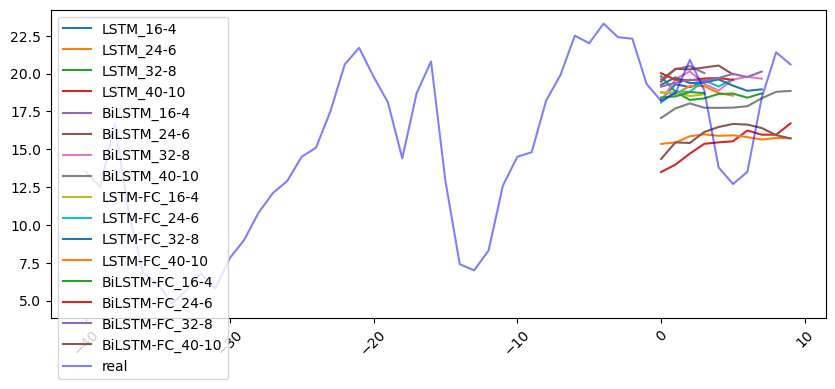

In [7]:
step = 40
real_output = scaler.data_range_[-1] * test[40 - step:50, -1] + scaler.data_min_[-1]
plt.figure(figsize=(10,4))
for key, pred in predictions.items():
    plt.plot(np.arange(0, len(pred)), pred, label = key)
plt.plot(np.arange(-step, 10),real_output, label = 'real', color = 'blue', alpha = 0.5)
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [8]:
# splitting data into sequences
def split_sequences(features, target, seq_len, forecast_len):
    X,y = list(), list()
    for i in range(len(features)):
        end_input = i + seq_len
        end_predict = end_input + forecast_len
        if end_predict > len(features)-1:
            break
        seq_x, seq_y = features[i:end_input,:], target[end_input:end_predict]
        X.append(seq_x)
        y.append(seq_y)
    return tf.convert_to_tensor(X, dtype=tf.float64), tf.convert_to_tensor(y, dtype=tf.float64)

In [9]:
from sklearn.metrics import mean_squared_error

mse_all = dict()
rmse_all = dict()
predictions = dict()
mse = dict()
rmse = dict()
actual = dict()

for path in modelpath_list:
    model = tf.keras.models.load_model(path)
    in_out = path.split('_')[-1]
    input_len = int(in_out.split('-')[0])
    output_len = int(in_out.split('-')[1])
    
    X_train, y_train = split_sequences(train[:,:-1], train[:,-1], seq_len =  input_len, forecast_len = output_len)
    X_test, y_test = split_sequences(test[:,:-1], test[:,-1],seq_len = input_len, forecast_len =  output_len)
    n_features = X_train.shape[2]
    
    y_hat_test = scaler.data_range_[-1] * model.predict(X_test) + scaler.data_min_[-1] 
    y_test = scaler.data_range_[-1] * y_test + scaler.data_min_[-1] 
    
    y_hat_train = scaler.data_range_[-1] * model.predict(X_train) + scaler.data_min_[-1] 
    y_train = scaler.data_range_[-1] * y_train + scaler.data_min_[-1] 
    
    mse_all[model.name] = [mean_squared_error(y_train, y_hat_train) , mean_squared_error(y_test, y_hat_test)]
    rmse_all[model.name] = np.sqrt(mse_all[model.name])
    predictions[model.name] = [y_hat_train, y_hat_test]
    actual[model.name] = [y_train, y_test]
    
    mse[model.name] = []
    rmse[model.name] = []
    for i in range(output_len):
        mse[model.name].append(mean_squared_error(y_test[:,i], y_hat_test[:,i]))
        rmse[model.name].append(mean_squared_error(y_test[:,i], y_hat_test[:,i], squared = False))

In [10]:
with open('./mse_all_daily_v2.pkl', 'wb') as f:
    pickle.dump(mse_all, f)
with open('./rmse_all_daily_v2.pkl', 'wb') as f:
    pickle.dump(rmse_all, f)
with open('./predictions_daily_v2.pkl', 'wb') as f:
    pickle.dump(predictions, f)
with open('./actual_daily_v2.pkl', 'wb') as f:
    pickle.dump(actual, f)
    
with open('./mse_daily_v2.pkl', 'wb') as f:
    pickle.dump(mse, f)
with open('./rmse_daily_v2.pkl', 'wb') as f:
    pickle.dump(rmse, f)

In [6]:
with open('./mse_all_daily_v2.pkl', 'rb') as f:
    mse_all = pickle.load(f)
with open('./rmse_all_daily_v2.pkl', 'rb') as f:
    rmse_all = pickle.load(f)
with open('./predictions_daily_v2.pkl', 'rb') as f:
    predictions = pickle.load(f)
with open('./actual_daily_v2.pkl', 'rb') as f:
    actual = pickle.load(f)
    
with open('./mse_daily_v2.pkl', 'rb') as f:
    mse = pickle.load(f)
with open('./rmse_daily_v2.pkl', 'rb') as f:
    rmse = pickle.load(f)

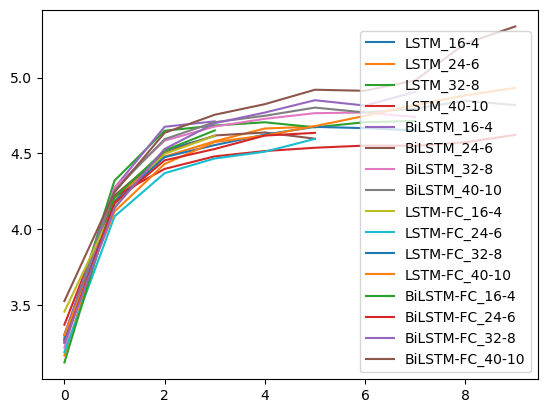

In [7]:
for key, item in rmse.items():
    plt.plot(item, label = key)
plt.legend()
plt.show()

In [15]:
rmse['BiLSTM-FC_16-4']

[3.1215853602550205, 4.207920183737327, 4.518577838302086, 4.651125564729271]

In [14]:
mse_all

{'LSTM_16-4': [17.464244113647656, 17.535403844620742],
 'LSTM_24-6': [17.88721157915722, 18.73006813231466],
 'LSTM_32-8': [18.396434549011957, 20.154982268558285],
 'LSTM_40-10': [19.15140378738215, 19.321558836461367],
 'BiLSTM_16-4': [17.73352934425655, 18.302116631509712],
 'BiLSTM_24-6': [17.146160924572857, 18.78979603741821],
 'BiLSTM_32-8': [17.58783950497635, 20.224273136261544],
 'BiLSTM_40-10': [16.850247110935182, 21.020091303512665],
 'LSTM-FC_16-4': [17.659915867704708, 17.676561216184524],
 'LSTM-FC_24-6': [18.327954310923882, 17.89334927663234],
 'LSTM-FC_32-8': [19.344760440477486, 19.441515495376578],
 'LSTM-FC_40-10': [19.616839652906428, 20.554608606133918],
 'BiLSTM-FC_16-4': [15.790263150317507, 17.375350533433842],
 'BiLSTM-FC_24-6': [16.690375967935275, 18.524894440068],
 'BiLSTM-FC_32-8': [19.08817608600675, 20.475776241179332],
 'BiLSTM-FC_40-10': [19.18978079367461, 22.67247407316044]}

In [15]:
rmse_all

{'LSTM_16-4': array([4.1790243 , 4.18752956]),
 'LSTM_24-6': array([4.22932756, 4.32782487]),
 'LSTM_32-8': array([4.2891065 , 4.48943006]),
 'LSTM_40-10': array([4.37623169, 4.39562952]),
 'BiLSTM_16-4': array([4.21111973, 4.27809731]),
 'BiLSTM_24-6': array([4.14079231, 4.33471983]),
 'BiLSTM_32-8': array([4.19378582, 4.49714055]),
 'BiLSTM_40-10': array([4.10490525, 4.58476731]),
 'LSTM-FC_16-4': array([4.20237027, 4.20435027]),
 'LSTM-FC_24-6': array([4.28111601, 4.23005311]),
 'LSTM-FC_32-8': array([4.39826789, 4.40925339]),
 'LSTM-FC_40-10': array([4.42909016, 4.53371907]),
 'BiLSTM-FC_16-4': array([3.97369641, 4.16837505]),
 'BiLSTM-FC_24-6': array([4.08538566, 4.30405558]),
 'BiLSTM-FC_32-8': array([4.36900173, 4.52501671]),
 'BiLSTM-FC_40-10': array([4.3806142 , 4.76156215])}

In [16]:
rmse_df = pd.DataFrame(rmse_all).T

In [17]:
rmse_df.columns = ['Train', 'Test']

In [18]:
rmse_df

Train      Test
LSTM_16-4        4.179024  4.187530
LSTM_24-6        4.229328  4.327825
LSTM_32-8        4.289106  4.489430
LSTM_40-10       4.376232  4.395630
BiLSTM_16-4      4.211120  4.278097
BiLSTM_24-6      4.140792  4.334720
BiLSTM_32-8      4.193786  4.497141
BiLSTM_40-10     4.104905  4.584767
LSTM-FC_16-4     4.202370  4.204350
LSTM-FC_24-6     4.281116  4.230053
LSTM-FC_32-8     4.398268  4.409253
LSTM-FC_40-10    4.429090  4.533719
BiLSTM-FC_16-4   3.973696  4.168375
BiLSTM-FC_24-6   4.085386  4.304056
BiLSTM-FC_32-8   4.369002  4.525017
BiLSTM-FC_40-10  4.380614  4.761562

In [19]:
print(rmse_df.to_latex(index=True,  float_format="{:.4f}".format))

\begin{tabular}{lrr}
\toprule
{} &  Train &   Test \\
\midrule
LSTM\_16-4       & 4.1790 & 4.1875 \\
LSTM\_24-6       & 4.2293 & 4.3278 \\
LSTM\_32-8       & 4.2891 & 4.4894 \\
LSTM\_40-10      & 4.3762 & 4.3956 \\
BiLSTM\_16-4     & 4.2111 & 4.2781 \\
BiLSTM\_24-6     & 4.1408 & 4.3347 \\
BiLSTM\_32-8     & 4.1938 & 4.4971 \\
BiLSTM\_40-10    & 4.1049 & 4.5848 \\
LSTM-FC\_16-4    & 4.2024 & 4.2044 \\
LSTM-FC\_24-6    & 4.2811 & 4.2301 \\
LSTM-FC\_32-8    & 4.3983 & 4.4093 \\
LSTM-FC\_40-10   & 4.4291 & 4.5337 \\
BiLSTM-FC\_16-4  & 3.9737 & 4.1684 \\
BiLSTM-FC\_24-6  & 4.0854 & 4.3041 \\
BiLSTM-FC\_32-8  & 4.3690 & 4.5250 \\
BiLSTM-FC\_40-10 & 4.3806 & 4.7616 \\
\bottomrule
\end{tabular}



In [20]:
predictions

{'LSTM_16-4': [array([[ 8.858992 ,  9.088352 ,  9.379675 ,  9.986851 ],
         [ 7.290043 ,  9.123594 ,  9.56675  ,  9.9358425],
         [10.825968 , 12.299593 , 11.681055 , 11.678164 ],
         ...,
         [ 8.555117 ,  7.8140717,  7.4332485,  8.003672 ],
         [ 5.0129185,  5.976492 ,  6.4329815,  7.1804714],
         [ 2.8097897,  5.488716 ,  6.151657 ,  6.7371387]], dtype=float32),
  array([[12.844252  , 12.121237  , 11.318842  , 11.715105  ],
         [14.112253  , 13.690977  , 12.710211  , 12.971388  ],
         [16.369074  , 15.249792  , 13.992891  , 14.125723  ],
         ...,
         [ 2.3949776 ,  3.9232388 ,  4.354971  ,  4.867811  ],
         [ 4.240448  ,  4.395712  ,  4.4178085 ,  4.6859207 ],
         [ 0.15750694,  2.8488922 ,  3.4087868 ,  3.9296532 ]],
        dtype=float32)],
 'LSTM_24-6': [array([[12.03916  , 11.502302 , 11.429338 , 11.311289 , 10.812033 ,
          10.905626 ],
         [11.177275 , 11.975237 , 12.353651 , 12.210325 , 11.645983 ,
        

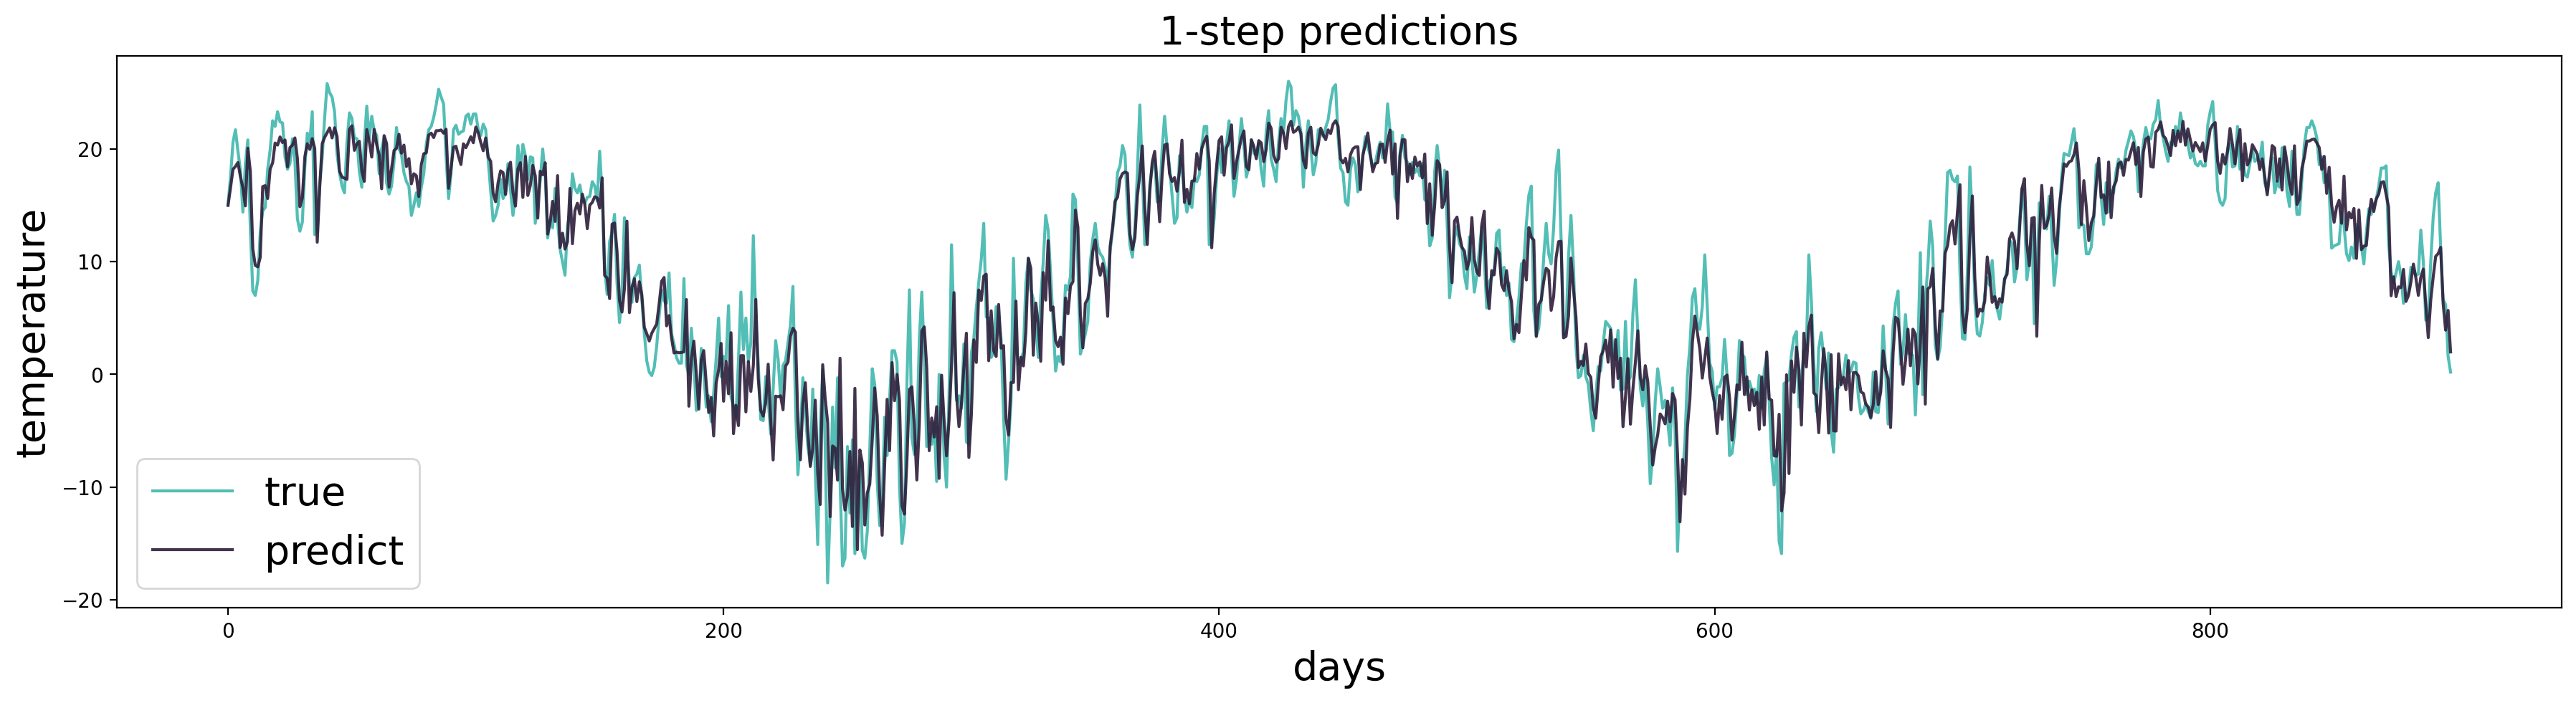

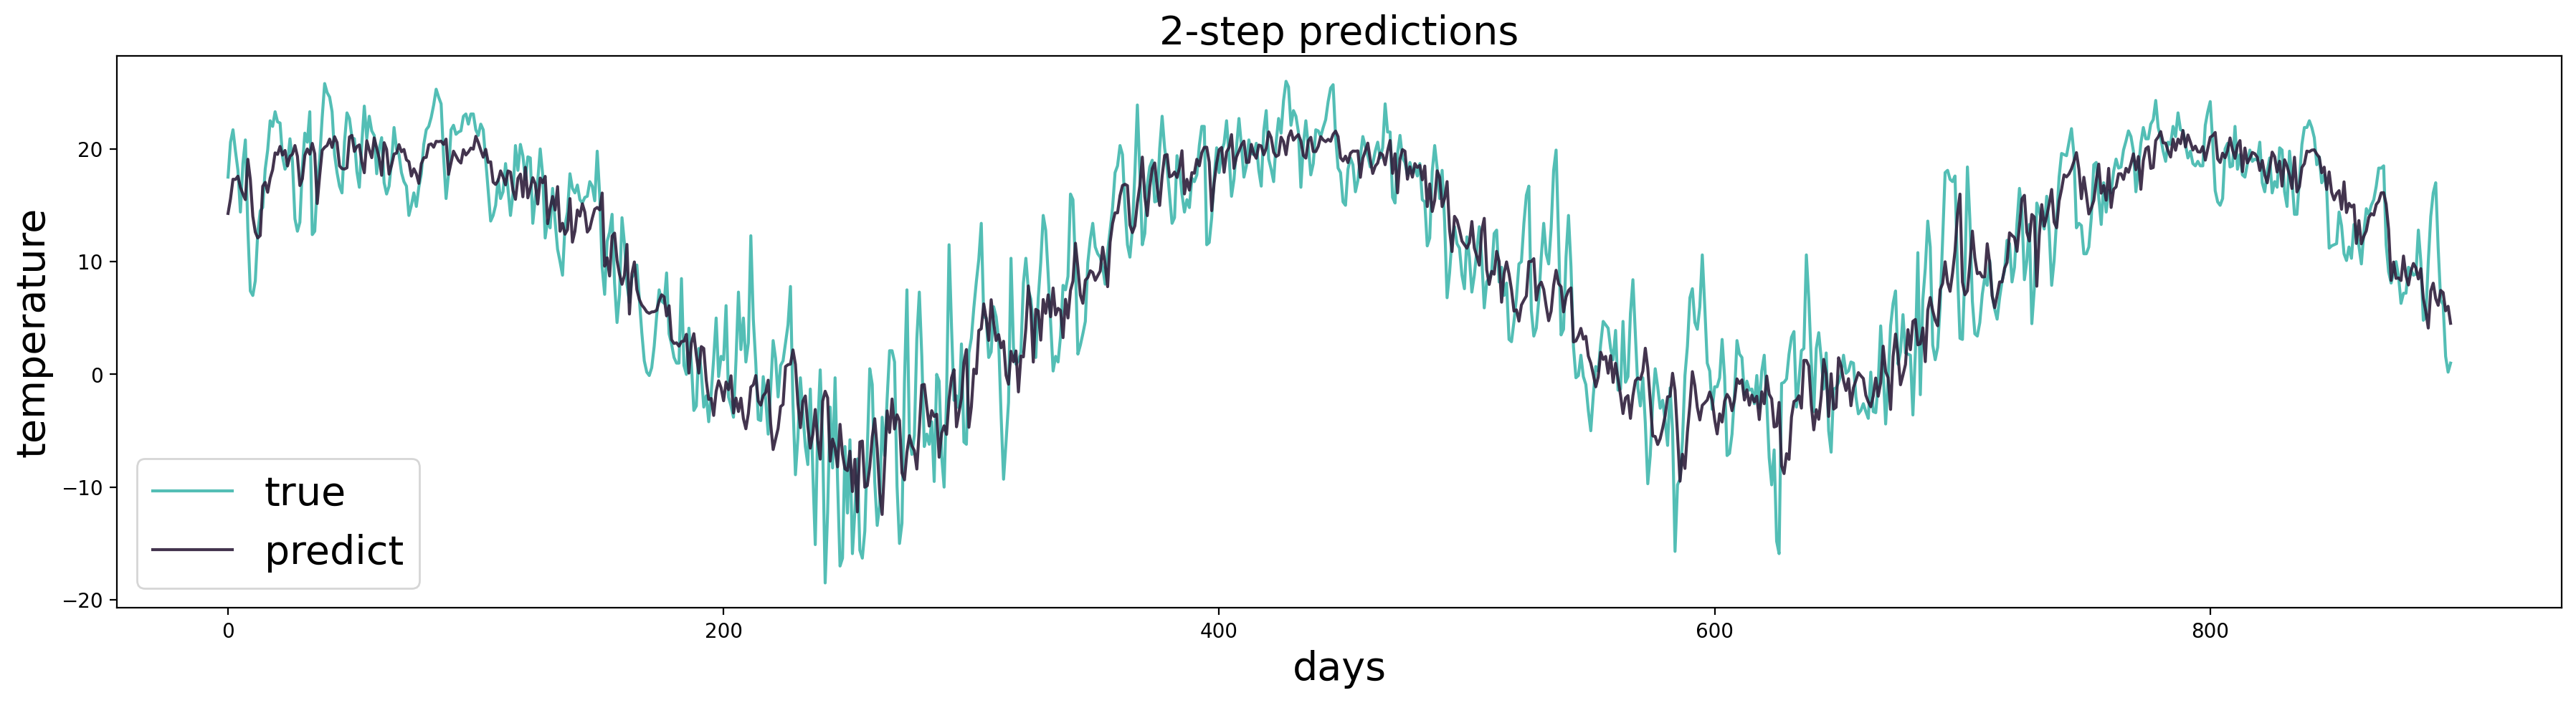

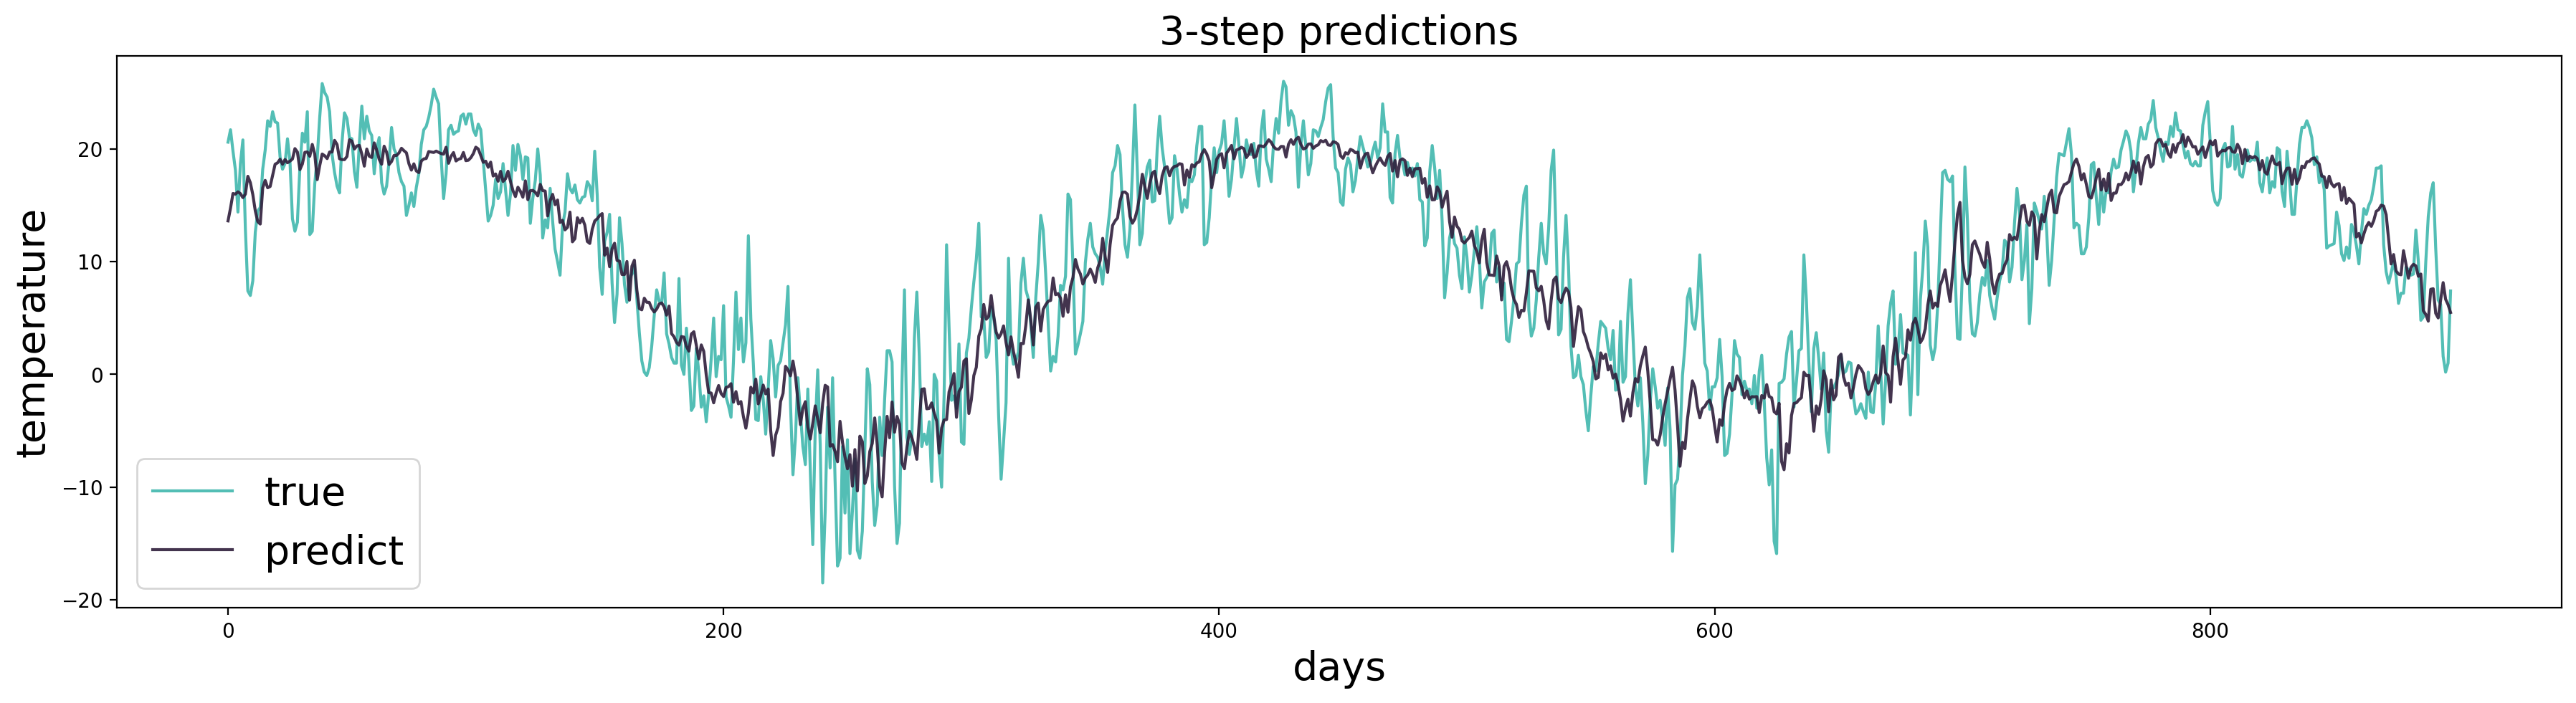

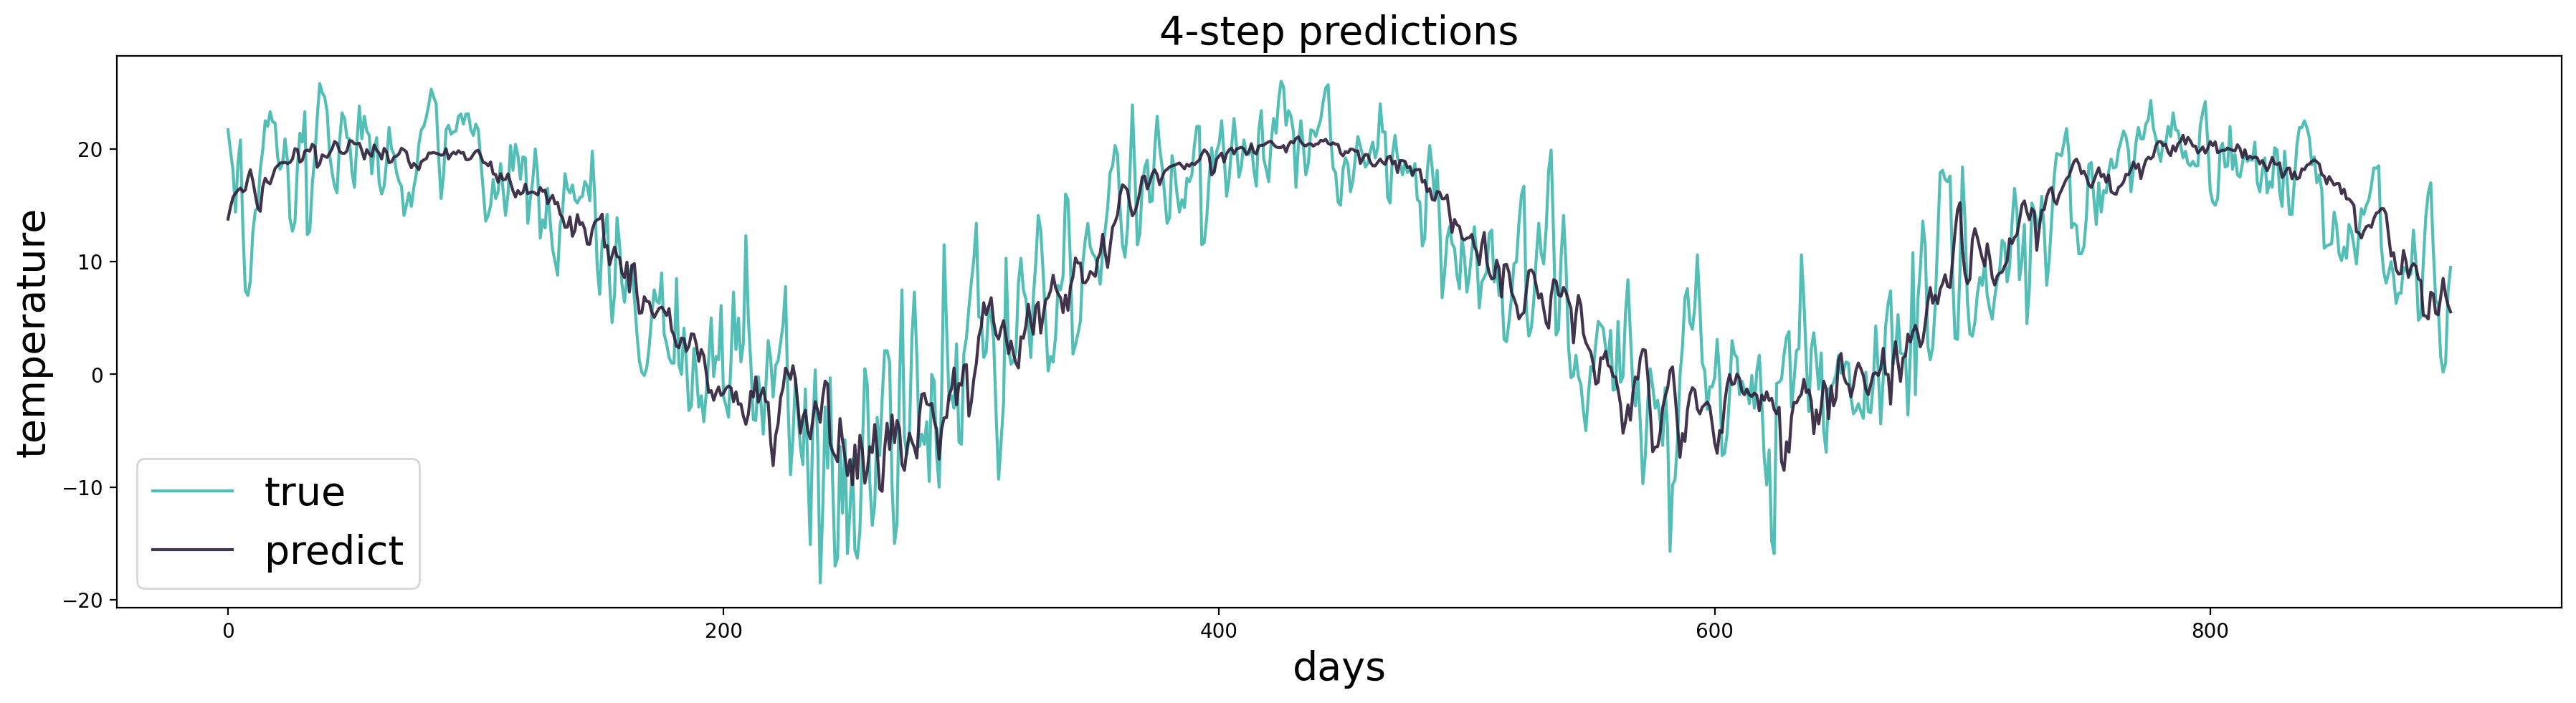

In [21]:
def plot_forecast(true, pred, title):
    fig, ax = plt.subplots(1, 1, figsize=(22, 5), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)
    ax.plot(true, label = 'true', color = palette[1], alpha = 0.9)
    ax.plot(pred, label = 'predict', color = palette[-1], alpha = 0.9)
    plt.legend(fontsize=fontsize)
    plt.xlabel('days', fontsize=fontsize)
    plt.ylabel('temperature', fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.show()

for i in range(4):
    plot_forecast(actual['BiLSTM-FC_16-4'][1][:,i], predictions['BiLSTM-FC_16-4'][1][:,i], title = str(i+1) + '-step predictions')

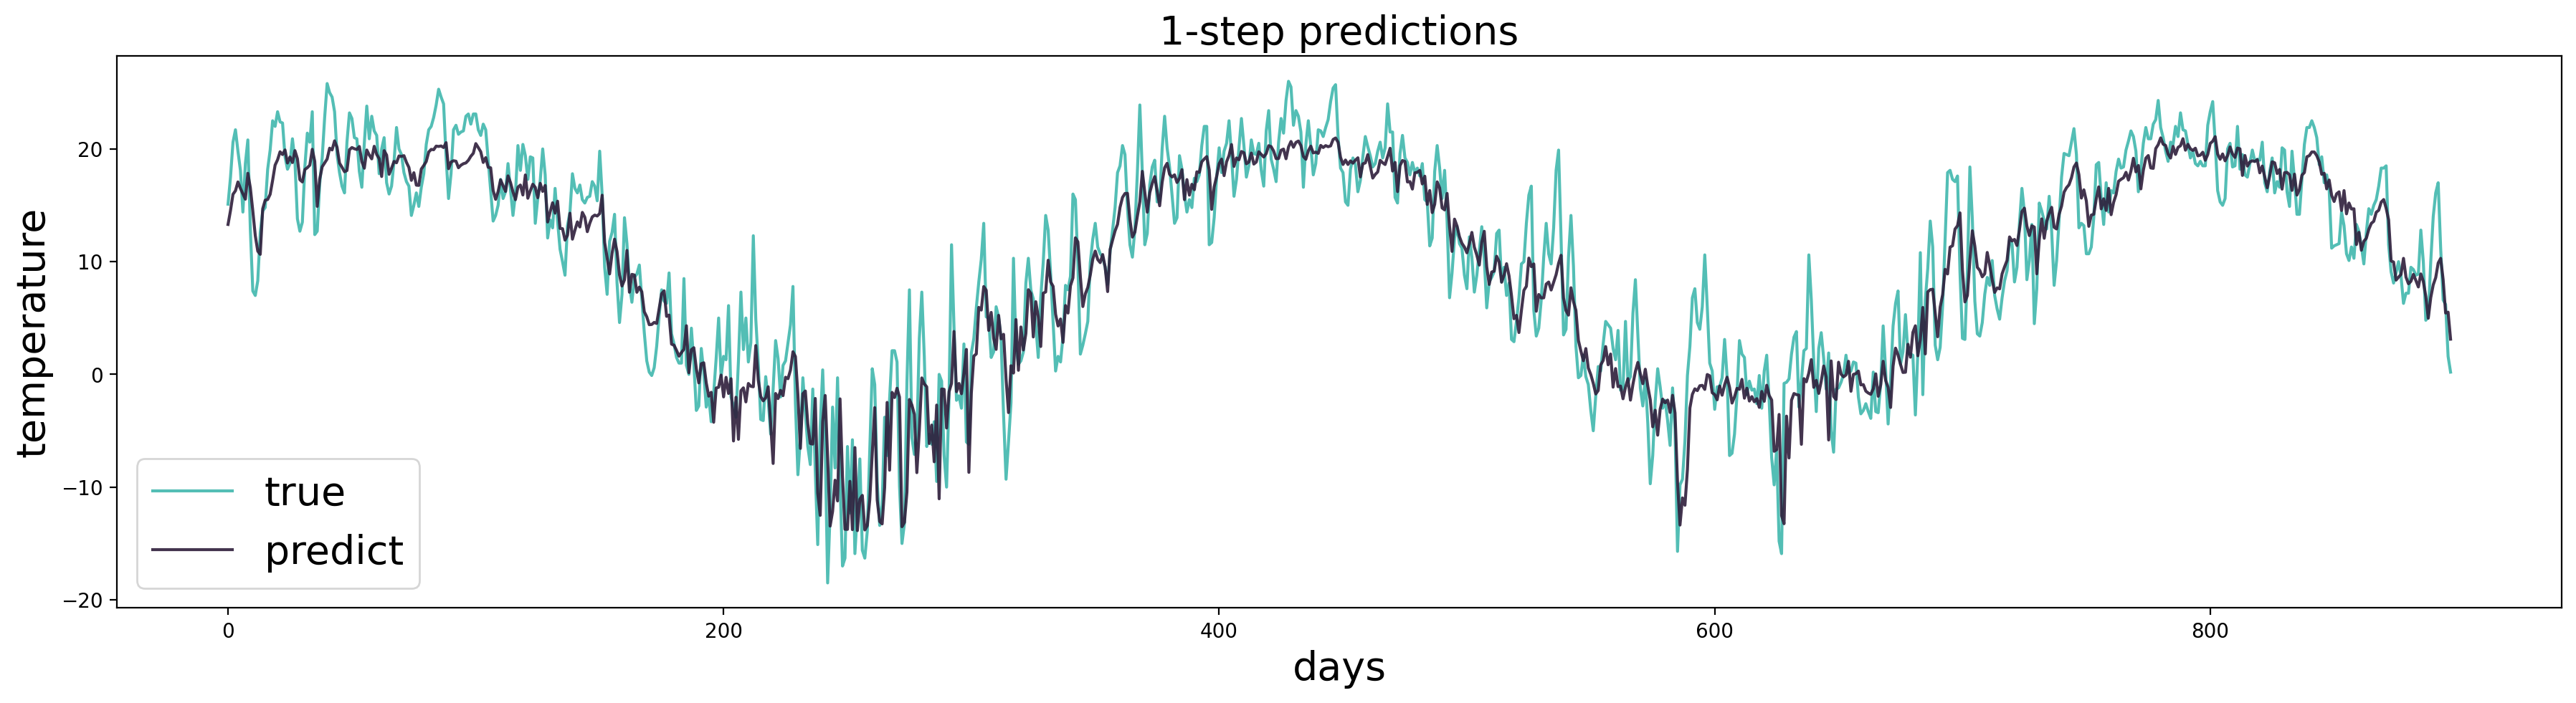

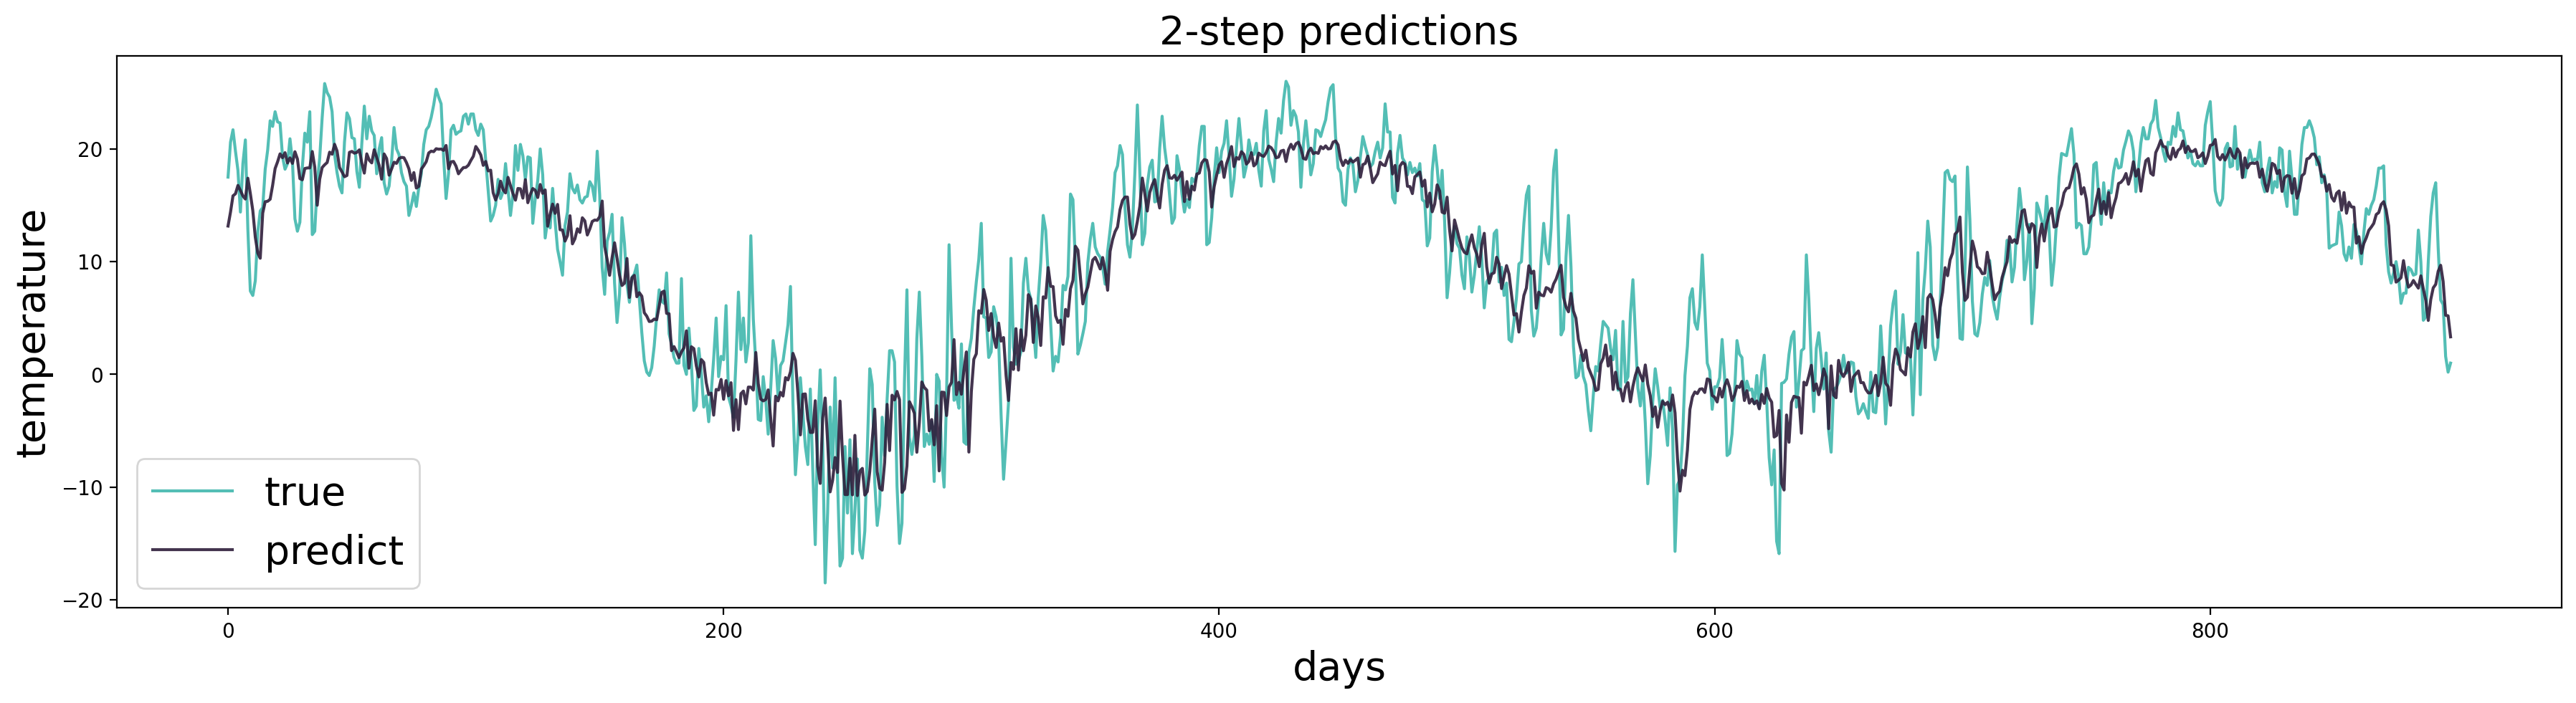

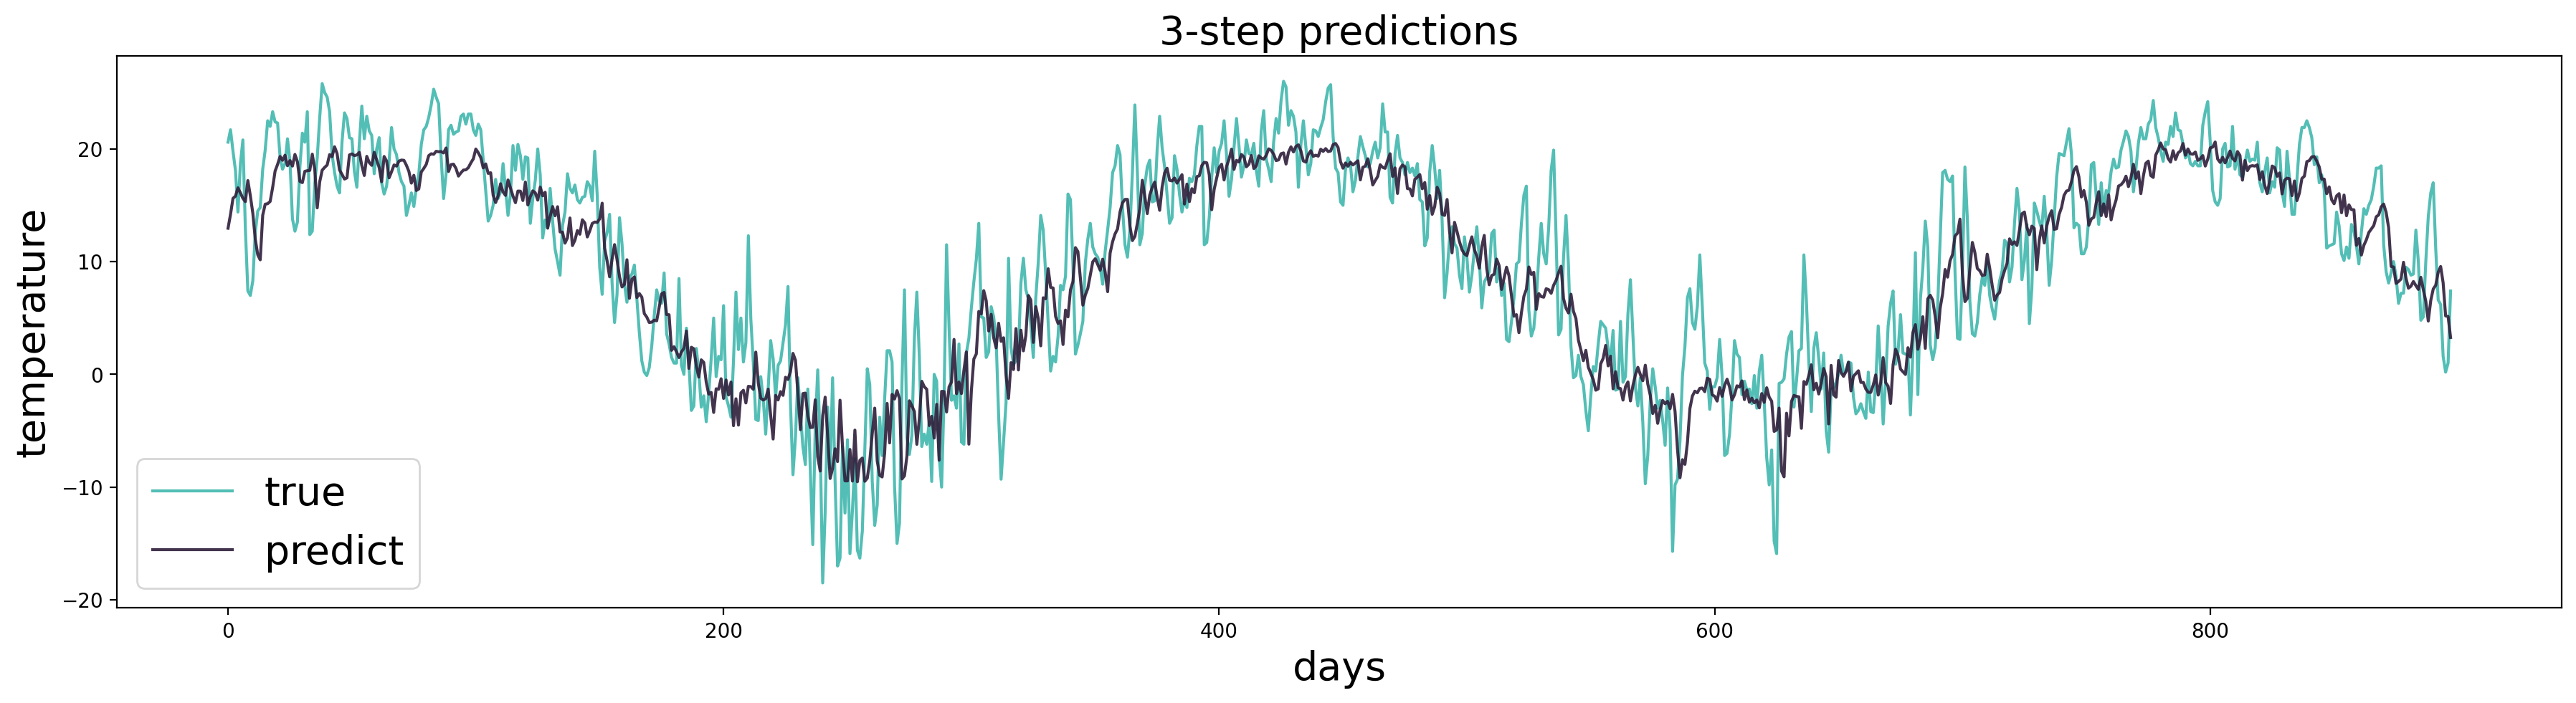

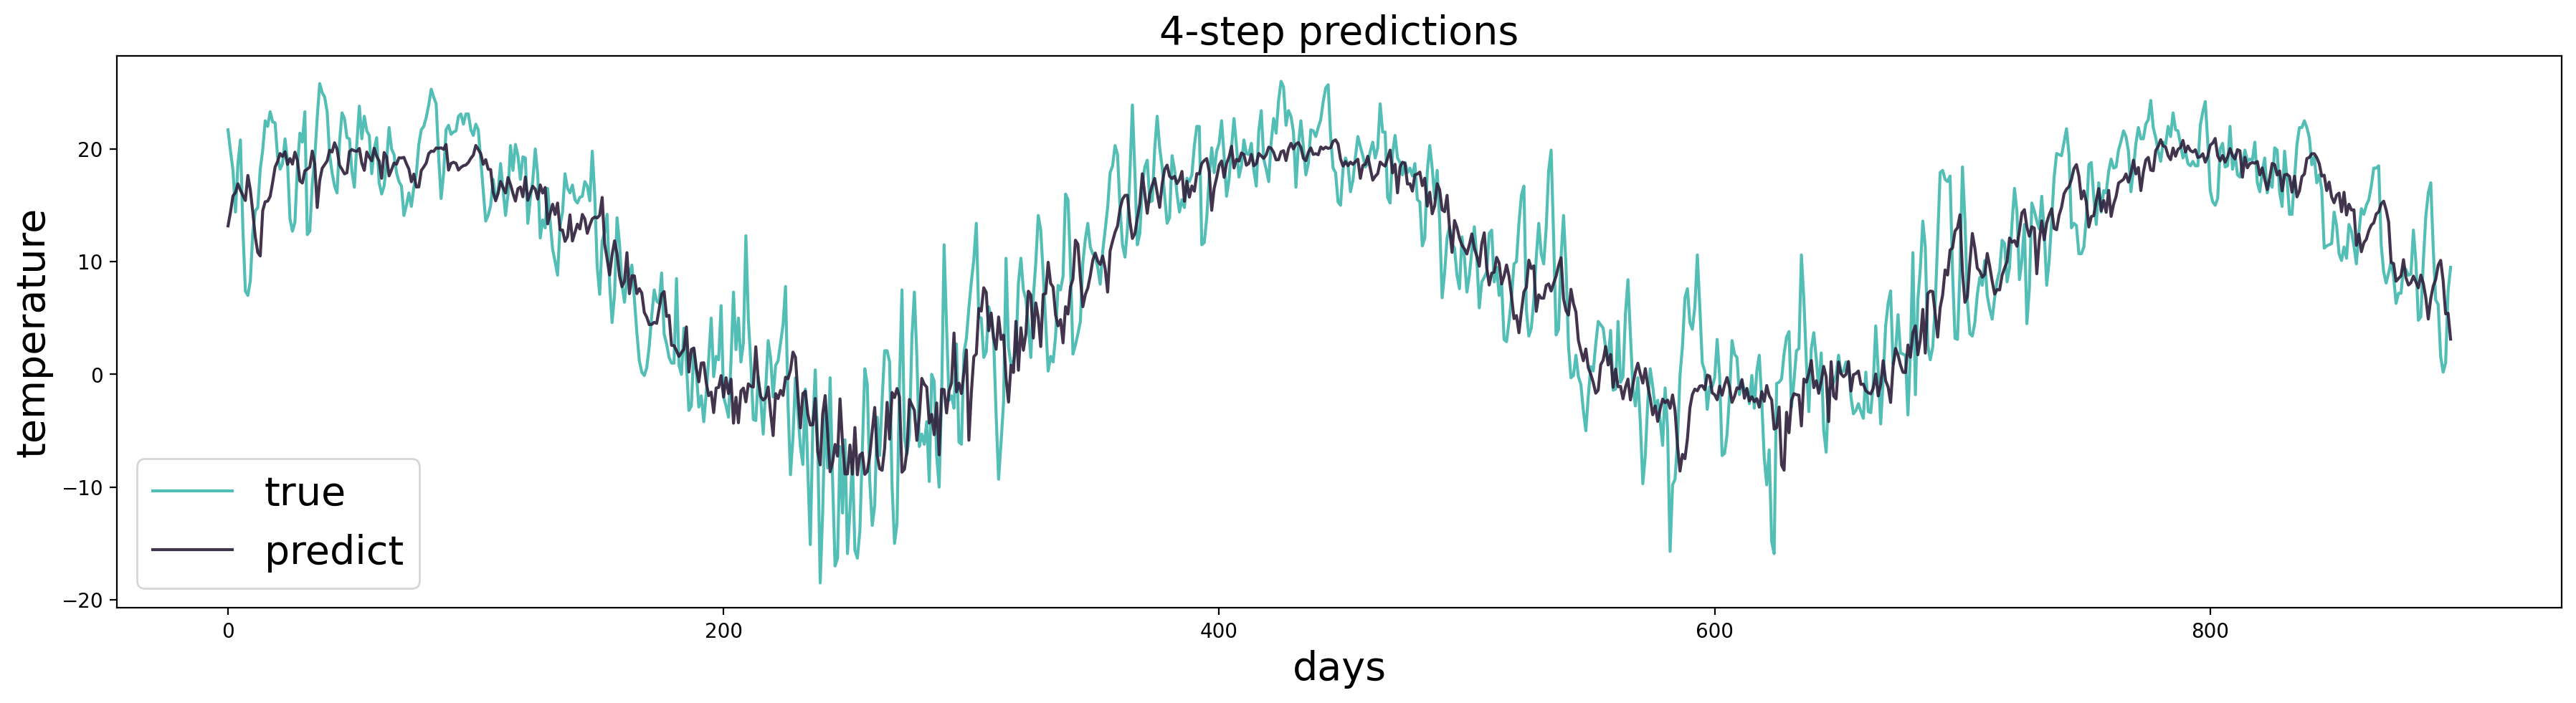

In [22]:
for i in range(4):
    plot_forecast(actual['LSTM-FC_16-4'][1][:,i], predictions['LSTM-FC_16-4'][1][:,i], title = str(i+1) + '-step predictions')

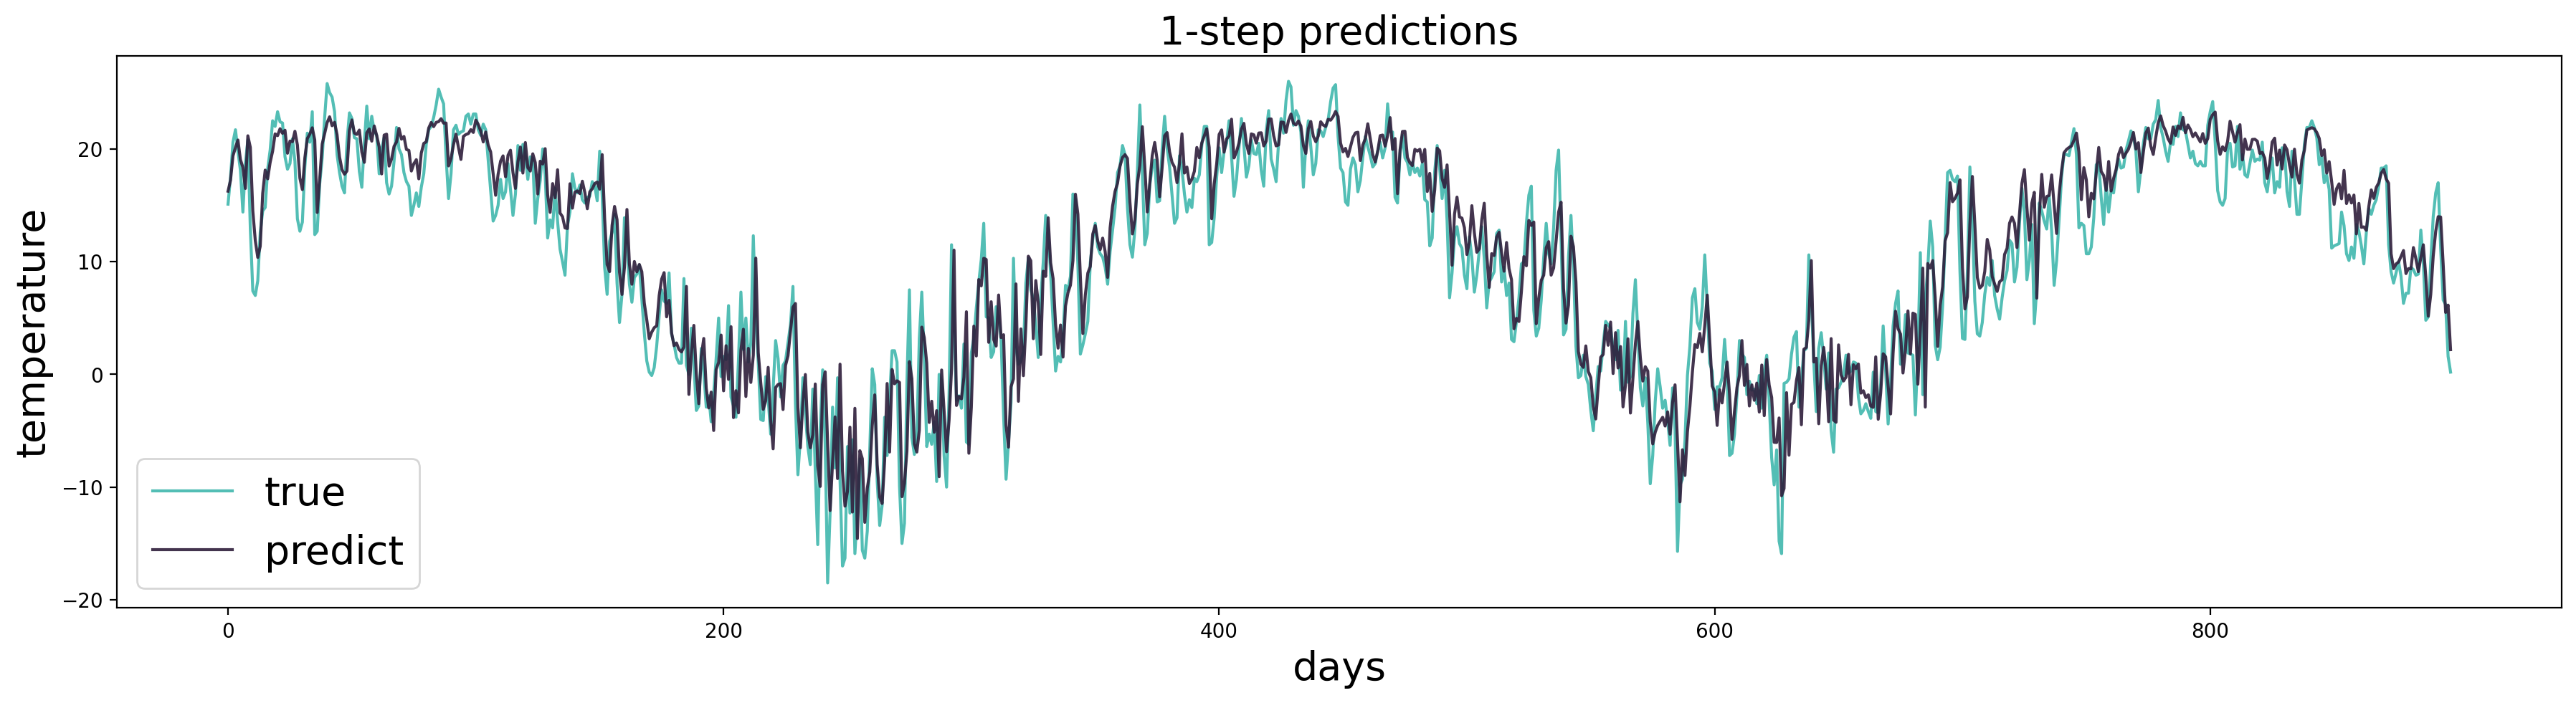

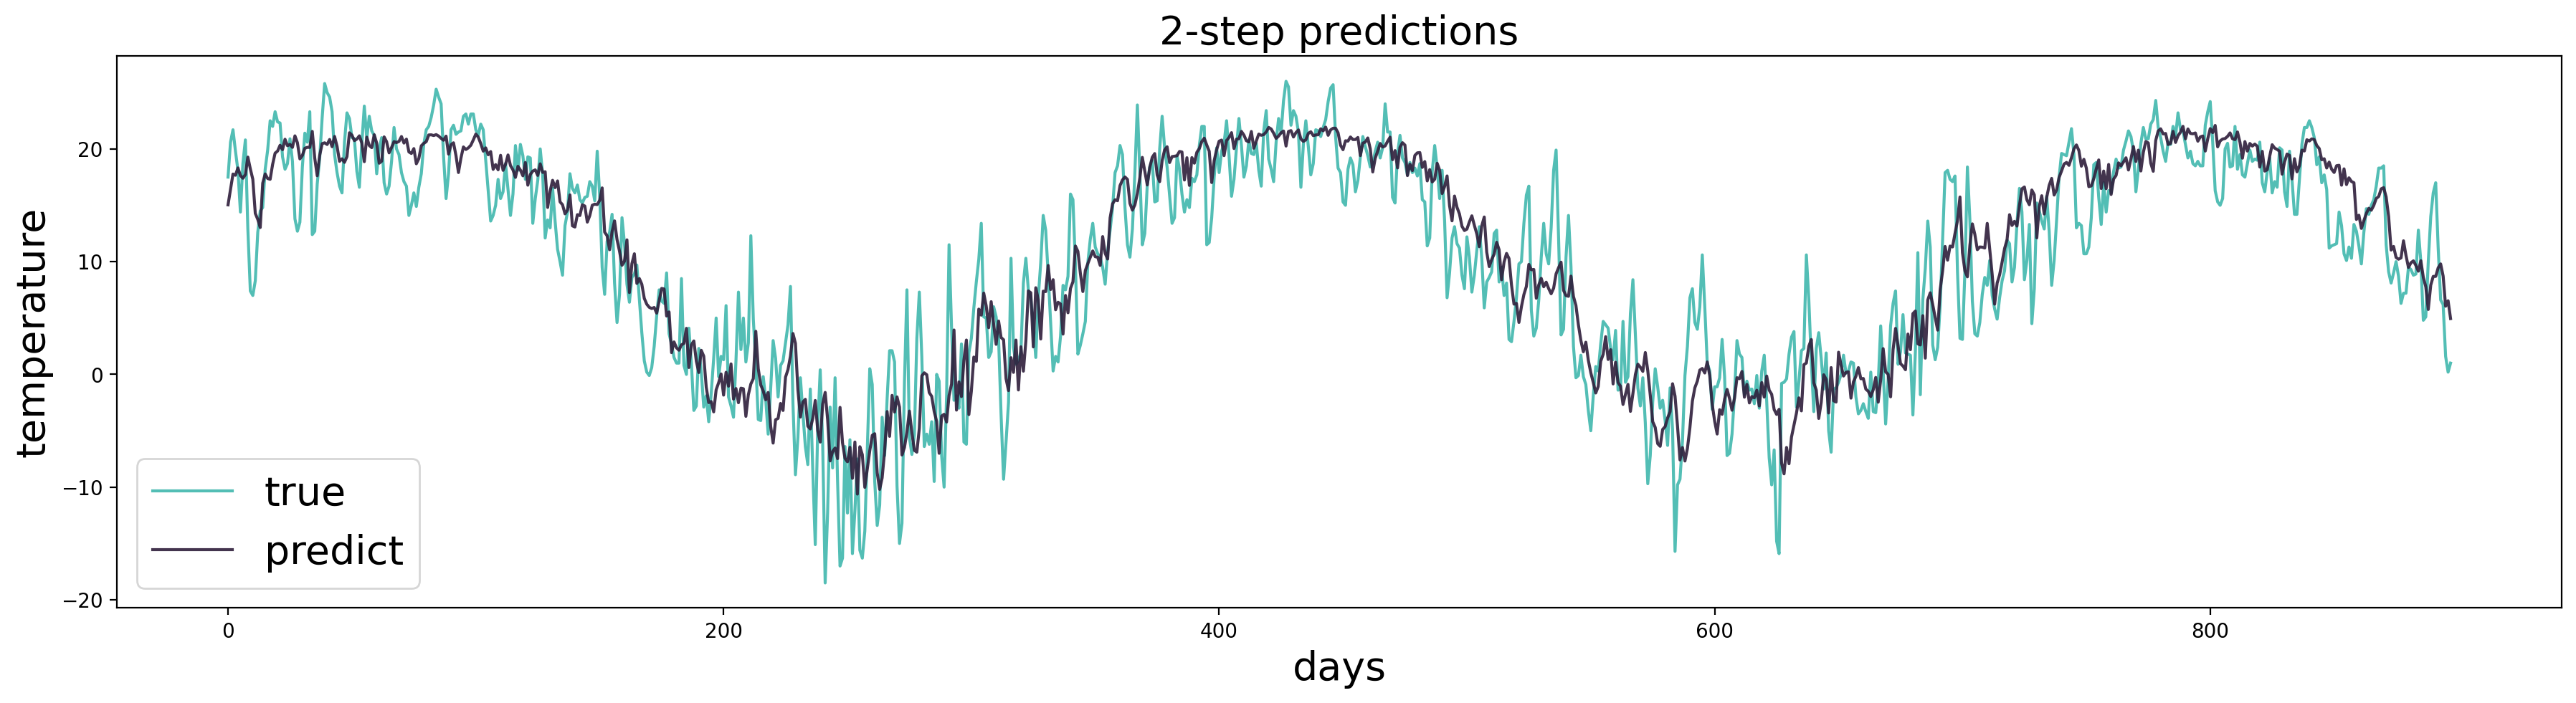

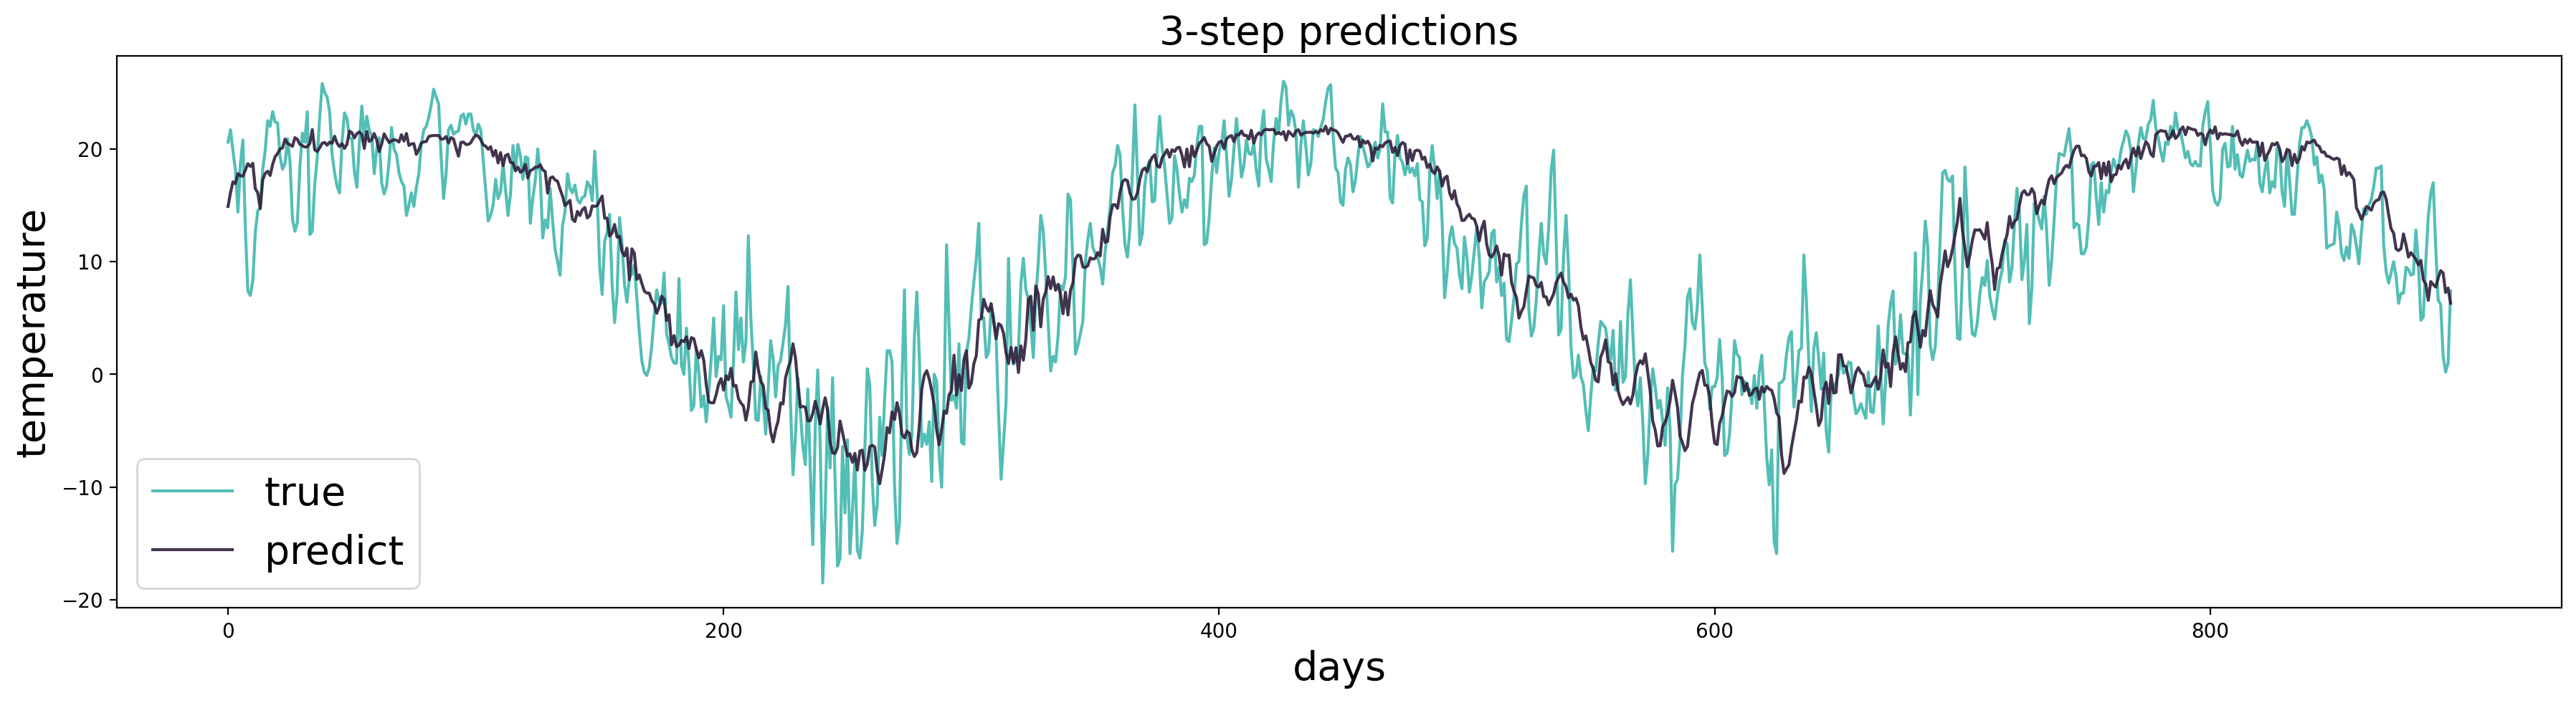

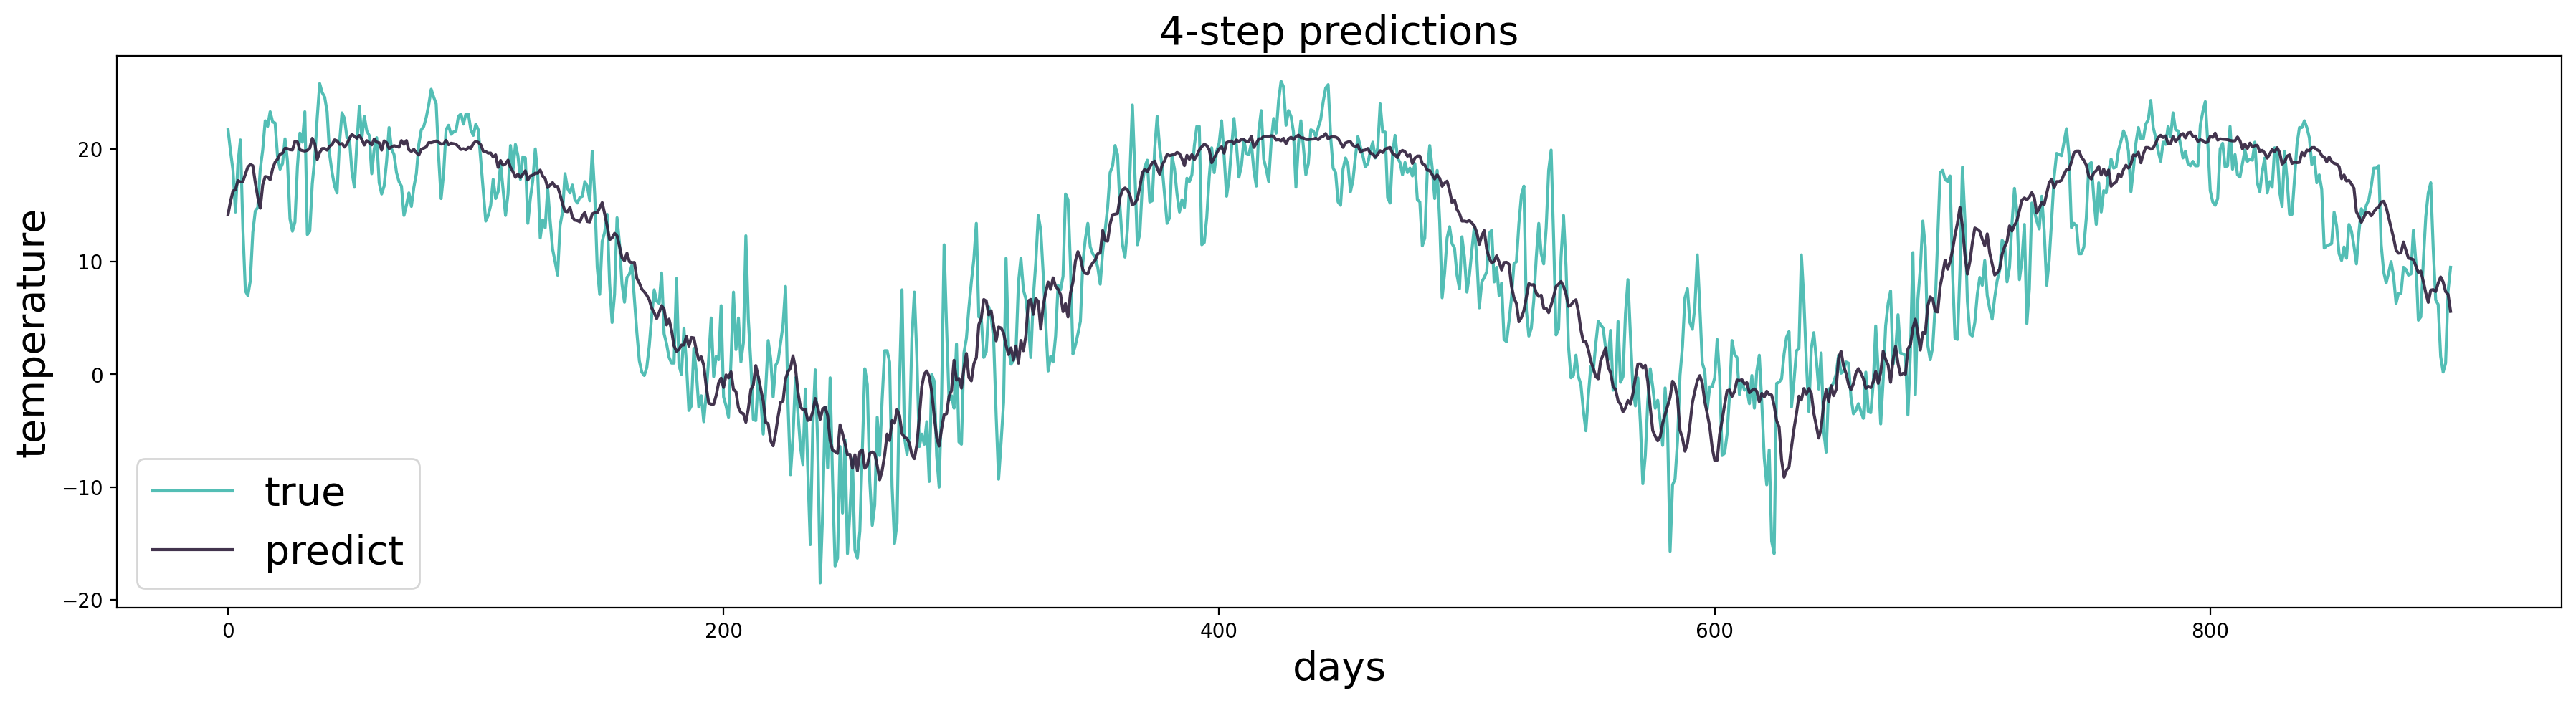

In [23]:
for i in range(4):
    plot_forecast(actual['BiLSTM_16-4'][1][:,i], predictions['BiLSTM_16-4'][1][:,i], title = str(i+1) + '-step predictions')